In [1]:
import numpy as np
import pandas as pd
from sklearn import tree, model_selection
from sklearn import tree, ensemble, model_selection, metrics
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from bayes_opt import BayesianOptimization
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PKN\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
Th

### Load all json files

In [2]:
portfolio = pd.read_json('F:/Customer Analytics and Applications/Project/data/portfolio.json', lines = True)
profile = pd.read_json('F:/Customer Analytics and Applications/Project/data/profile.json', lines = True)
transcript = pd.read_json('F:/Customer Analytics and Applications/Project/data/transcript.json', lines = True)

In [3]:
pd.set_option('display.max_columns',50)

### Portfolio data preparation

In [4]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [5]:
portfolio = portfolio.explode('channels')

In [6]:
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['channels'], prefix = 'Is Offer on', prefix_sep = ' ')], axis = 1).drop('channels', axis = 1)

In [7]:
portfolio = portfolio.groupby(['id','reward','difficulty','duration','offer_type'], as_index = False).agg({'Is Offer on email': np.sum,
                                                         'Is Offer on mobile': np.sum,
                                                         'Is Offer on social': np.sum,
                                                         'Is Offer on web': np.sum})

In [8]:
portfolio = portfolio.rename(columns={"id": "offer_id"})

In [9]:
portfolio

,offer_id,reward,difficulty,duration,offer_type,Is Offer on email,Is Offer on mobile,Is Offer on social,Is Offer on web
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,20,10,discount,1,0,0,1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3,7,7,discount,1,1,1,1
2,2906b810c7d4411798c6938adc9daaa5,2,10,7,discount,1,1,0,1
3,3f207df678b143eea3cee63160fa8bed,0,0,4,informational,1,1,0,1
4,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,bogo,1,1,1,1
5,5a8bc65990b245e5a138643cd4eb9837,0,0,3,informational,1,1,1,0
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,0,1
7,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,bogo,1,1,1,0
8,f19421c1d4aa40978ebb69ca19b0e20d,5,5,5,bogo,1,1,1,1
9,fafdcd668e3743c1bb461111dcafc2a4,2,10,10,discount,1,1,1,1


### Profile data preparation

In [10]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [11]:
profile.shape

(17000, 5)

In [12]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [13]:
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [14]:
# Impute missing values in Income column using mean value
profile['income'] = profile['income'].fillna(65404.991568) 

In [15]:
profile['gender'] = profile['gender'].fillna('Unwilling to specify')

In [16]:
profile = profile.rename(columns={"id": "person"})

In [17]:
profile.head(10)

,gender,age,person,became_member_on,income
0,Unwilling to specify,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000
2,Unwilling to specify,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000
4,Unwilling to specify,118,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.000000
6,Unwilling to specify,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,65404.991568
7,Unwilling to specify,118,68617ca6246f4fbc85e91a2a49552598,20171002,65404.991568
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.000000
9,Unwilling to specify,118,8974fc5686fe429db53ddde067b88302,20161122,65404.991568


In [18]:
import datetime

In [19]:
profile['join_month'] = pd.Series()
profile['became_member_on'] = profile['became_member_on'].astype('str')
months = []
for i in profile['became_member_on']:
    months.append(i[4:6])
                 
profile['join_month'] = months
profile['join_month'] = profile['join_month'].astype('int')

In [20]:
profile.head(10)

,gender,age,person,became_member_on,income,join_month
0,Unwilling to specify,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,2
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,7
2,Unwilling to specify,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568,7
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000,5
4,Unwilling to specify,118,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568,8
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,4
6,Unwilling to specify,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,65404.991568,9
7,Unwilling to specify,118,68617ca6246f4fbc85e91a2a49552598,20171002,65404.991568,10
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.000000,2
9,Unwilling to specify,118,8974fc5686fe429db53ddde067b88302,20161122,65404.991568,11


### Transcript data preparation

In [21]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [22]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


In [23]:
## Remove offer id and amount from dictionary data type inside value column - Transfer the values to new column

In [24]:
values=[]
for i in transcript['value']:
    values.append(list(i.values())[0])  

In [25]:
transcript['value_new'] = pd.Series()

In [26]:
transcript['value_new'] = values

In [27]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,value,time,value_new
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6,9b98b8c7a33c4b65b9aebfe6a799e6d9
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132,19.89
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132,9b98b8c7a33c4b65b9aebfe6a799e6d9
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144,17.78
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,5a8bc65990b245e5a138643cd4eb9837
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216,5a8bc65990b245e5a138643cd4eb9837
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222,19.67
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240,29.72
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378,23.93


In [28]:
transcript = transcript.sort_values(['person','time'], ascending = True)

In [29]:
offers = []
for i in transcript['value_new']:
    if type(i)==str:
        offers.append(i)
    else:
        j = offers[-1]
        offers.append(j) 
transcript['offer_id'] = offers 

In [30]:
amounts = []
for i in transcript['value_new']:
    if type(i)==str:
        amounts.append(0)
    else:
        amounts.append(i) 
transcript['transaction_amount'] = amounts 

In [31]:
del transcript['value'], transcript['value_new']

In [32]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,event,time,offer_id,transaction_amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.78
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,0.00
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,0.00
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,5a8bc65990b245e5a138643cd4eb9837,19.67
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,5a8bc65990b245e5a138643cd4eb9837,29.72
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,5a8bc65990b245e5a138643cd4eb9837,23.93


In [33]:
transcript_new = pd.concat([transcript, pd.get_dummies(transcript['event'], prefix = 'event', prefix_sep = '_=_')], axis = 1).drop('event', axis = 1)

In [34]:
transcript_new[transcript_new['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,time,offer_id,transaction_amount,event_=_offer completed,event_=_offer received,event_=_offer viewed,event_=_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,1,0,0
15561,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,0,0,1,0
47582,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,19.89,0,0,0,1
47583,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,1,0,0,0
49502,78afa995795e4d85b5d9ceeca43f5fef,144,9b98b8c7a33c4b65b9aebfe6a799e6d9,17.78,0,0,0,1
53176,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,0.00,0,1,0,0
85291,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,0.00,0,0,1,0
87134,78afa995795e4d85b5d9ceeca43f5fef,222,5a8bc65990b245e5a138643cd4eb9837,19.67,0,0,0,1
92104,78afa995795e4d85b5d9ceeca43f5fef,240,5a8bc65990b245e5a138643cd4eb9837,29.72,0,0,0,1
141566,78afa995795e4d85b5d9ceeca43f5fef,378,5a8bc65990b245e5a138643cd4eb9837,23.93,0,0,0,1


In [35]:
transcript_new.columns

Index(['person', 'time', 'offer_id', 'transaction_amount',
       'event_=_offer completed', 'event_=_offer received',
       'event_=_offer viewed', 'event_=_transaction'],
      dtype='object')

In [36]:
transcript_new2 = transcript_new.groupby(['person','offer_id'], as_index = False).agg({'event_=_offer completed': np.sum,
                                                            'event_=_offer received':np.sum,
                                                            'event_=_offer viewed':np.sum})      

In [37]:
transcript_new3 = transcript_new.groupby('person', as_index = False).agg({'transaction_amount': np.sum,
                                                            'event_=_transaction':np.sum}) 

In [38]:
transcript_new2 = pd.DataFrame(transcript_new2)
transcript_new3 = pd.DataFrame(transcript_new3)

In [39]:
transcript_new2.head()

,person,offer_id,event_=_offer completed,event_=_offer received,event_=_offer viewed
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1


In [40]:
transcript_new3.head()

,person,transaction_amount,event_=_transaction
0,0009655768c64bdeb2e877511632db8f,127.60,8
1,00116118485d4dfda04fdbaba9a87b5c,4.09,3
2,0011e0d4e6b944f998e987f904e8c1e5,79.46,5
3,0020c2b971eb4e9188eac86d93036a77,196.86,8
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12


In [41]:
transcript_new4 = transcript_new2.merge(transcript_new3, on = 'person', how = 'left')

In [42]:
transcript_new4 = pd.DataFrame(transcript_new4)
transcript_new4.head()

,person,offer_id,event_=_offer completed,event_=_offer received,event_=_offer viewed,transaction_amount,event_=_transaction
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,127.6,8
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,127.6,8
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,127.6,8
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,127.6,8
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,127.6,8


In [43]:
transcript_new4[transcript_new4['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,offer_id,event_=_offer completed,event_=_offer received,event_=_offer viewed,transaction_amount,event_=_transaction
30553,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,0,1,1,159.27,7
30554,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,159.27,7
30555,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,159.27,7
30556,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,159.27,7


In [44]:
transcript_new4.shape

(65021, 7)

In [45]:
transcript_new4['event_=_offer completed'].value_counts()

0    36025
1    24793
2     3842
3      342
4       19
Name: event_=_offer completed, dtype: int64

In [46]:
transcript[(transcript['person']=='073fce5708884b30a28b65b3cb15a919')&(transcript['offer_id']=='9b98b8c7a33c4b65b9aebfe6a799e6d9')]

,person,event,time,offer_id,transaction_amount
2268,073fce5708884b30a28b65b3cb15a919,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
13189,073fce5708884b30a28b65b3cb15a919,offer viewed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
38456,073fce5708884b30a28b65b3cb15a919,transaction,84,9b98b8c7a33c4b65b9aebfe6a799e6d9,25.35
38457,073fce5708884b30a28b65b3cb15a919,offer completed,84,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
45653,073fce5708884b30a28b65b3cb15a919,transaction,120,9b98b8c7a33c4b65b9aebfe6a799e6d9,18.86
50604,073fce5708884b30a28b65b3cb15a919,transaction,150,9b98b8c7a33c4b65b9aebfe6a799e6d9,15.07
55466,073fce5708884b30a28b65b3cb15a919,offer received,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
66500,073fce5708884b30a28b65b3cb15a919,offer viewed,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00
87449,073fce5708884b30a28b65b3cb15a919,transaction,222,9b98b8c7a33c4b65b9aebfe6a799e6d9,15.21
87450,073fce5708884b30a28b65b3cb15a919,offer completed,222,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00


### Derive usage rate
#### Usage rate = (no of offers completed/no of offers received)*100

In [47]:
transcript_new4['usage_rate'] = (transcript_new4['event_=_offer completed']/transcript_new4['event_=_offer received'])*100

In [48]:
transcript_new4[transcript_new4['event_=_offer completed']==4]

,person,offer_id,event_=_offer completed,event_=_offer received,event_=_offer viewed,transaction_amount,event_=_transaction,usage_rate
1763,073fce5708884b30a28b65b3cb15a919,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,4,4,392.29,15,100.0
6989,1c8cf4af93464dcaa971cfcffc2cc1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,4,4,4,217.56,8,100.0
9717,281d463f31e74ecaa4451d169868c5d7,2298d6c36e964ae4a3e7e9706d1fb8c2,4,4,4,352.62,18,100.0
11258,2dab8c385a2440b78b432ecb72d68787,2298d6c36e964ae4a3e7e9706d1fb8c2,4,4,4,68.89,19,100.0
15878,3ead7d94371041fcab4db5fb57ced95c,ae264e3637204a6fb9bb56bc8210ddfd,4,4,3,157.14,15,100.0
18436,487ad048c0e248a8bf6eb1545f5be4c6,2906b810c7d4411798c6938adc9daaa5,4,4,1,368.99,18,100.0
19127,4b72995c52ab4cd5ab407924b09e1ab4,9b98b8c7a33c4b65b9aebfe6a799e6d9,4,4,4,561.59,13,100.0
24790,61f661b7070c4063880a85b22f1fe0e4,2906b810c7d4411798c6938adc9daaa5,4,4,4,104.74,7,100.0
29010,72412f41d944472dbba2183ae9af8a8e,2298d6c36e964ae4a3e7e9706d1fb8c2,4,4,3,209.71,8,100.0
37929,948ec827ac334c8782a1da99a2d6a39b,ae264e3637204a6fb9bb56bc8210ddfd,4,4,4,182.39,16,100.0


In [49]:
transcript_new4.describe()

,event_=_offer completed,event_=_offer received,event_=_offer viewed,transaction_amount,event_=_transaction,usage_rate
count,65021.000000,65021.000000,65021.000000,65021.000000,65021.000000,63288.000000
mean,0.516433,1.173113,0.887790,106.373816,8.337799,44.044737
std,0.634806,0.487895,0.623878,127.250114,5.173931,48.758883
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,22.370000,4.000000,0.000000
50%,0.000000,1.000000,1.000000,71.000000,7.000000,0.000000
75%,1.000000,1.000000,1.000000,151.460000,11.000000,100.000000
max,4.000000,5.000000,5.000000,1608.690000,36.000000,100.000000


In [50]:
transcript_new4 = transcript_new4[~transcript_new4['usage_rate'].isna()==True]

In [51]:
transcript_new4.shape

(63288, 8)

In [52]:
transcript_new4['usage_rate'].value_counts()

0.000000      34292
100.000000    26752
50.000000      1921
66.666667       154
33.333333       152
75.000000         9
25.000000         5
60.000000         1
40.000000         1
20.000000         1
Name: usage_rate, dtype: int64

### Merge all datasets into one and create target variable - Usage class:
#### 0%usage rate - Class 0 - No use category(will not use the offer at all)
#### Between 0-100%usage rate - Class 1 - Fickle minded category(will use the offer sometimes)
#### 100%usage rate - Class 2 - Sureshot users category(will use the given offer everytime)

In [53]:
df = transcript_new4.merge(portfolio, on = 'offer_id', how = 'left')

In [54]:
df = df.merge(profile, on = 'person',how = 'left')

In [55]:
df.head(10)

,person,offer_id,event_=_offer completed,event_=_offer received,event_=_offer viewed,transaction_amount,event_=_transaction,usage_rate,reward,difficulty,duration,offer_type,Is Offer on email,Is Offer on mobile,Is Offer on social,Is Offer on web,gender,age,became_member_on,income,join_month
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,127.60,8,100.0,2,10,7,discount,1,1,0,1,M,33,20170421,72000.000000,4
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,127.60,8,0.0,0,0,4,informational,1,1,0,1,M,33,20170421,72000.000000,4
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,127.60,8,0.0,0,0,3,informational,1,1,1,0,M,33,20170421,72000.000000,4
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,127.60,8,100.0,5,5,5,bogo,1,1,1,1,M,33,20170421,72000.000000,4
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,127.60,8,100.0,2,10,10,discount,1,1,1,1,M,33,20170421,72000.000000,4
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,2,2,4.09,3,0.0,5,5,5,bogo,1,1,1,1,Unwilling to specify,118,20180425,65404.991568,4
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,79.46,5,100.0,5,20,10,discount,1,0,0,1,O,40,20180109,57000.000000,1
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,79.46,5,100.0,3,7,7,discount,1,1,1,1,O,40,20180109,57000.000000,1
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,1,1,79.46,5,0.0,0,0,4,informational,1,1,0,1,O,40,20180109,57000.000000,1
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0,1,1,79.46,5,0.0,0,0,3,informational,1,1,1,0,O,40,20180109,57000.000000,1


In [56]:
df['usage_class'] = pd.Series()

In [57]:
usage_class = []
for i in df['usage_rate']:
    if i ==0.0:
        usage_class.append('0')
    elif i ==100.0:
        usage_class.append('2')
    else:
        usage_class.append('1')

In [58]:
df['usage_class'] = usage_class

In [59]:
df.head(10)

,person,offer_id,event_=_offer completed,event_=_offer received,event_=_offer viewed,transaction_amount,event_=_transaction,usage_rate,reward,difficulty,duration,offer_type,Is Offer on email,Is Offer on mobile,Is Offer on social,Is Offer on web,gender,age,became_member_on,income,join_month,usage_class
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,127.60,8,100.0,2,10,7,discount,1,1,0,1,M,33,20170421,72000.000000,4,2
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,127.60,8,0.0,0,0,4,informational,1,1,0,1,M,33,20170421,72000.000000,4,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,127.60,8,0.0,0,0,3,informational,1,1,1,0,M,33,20170421,72000.000000,4,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,127.60,8,100.0,5,5,5,bogo,1,1,1,1,M,33,20170421,72000.000000,4,2
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,127.60,8,100.0,2,10,10,discount,1,1,1,1,M,33,20170421,72000.000000,4,2
5,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,0,2,2,4.09,3,0.0,5,5,5,bogo,1,1,1,1,Unwilling to specify,118,20180425,65404.991568,4,0
6,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,79.46,5,100.0,5,20,10,discount,1,0,0,1,O,40,20180109,57000.000000,1,2
7,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,79.46,5,100.0,3,7,7,discount,1,1,1,1,O,40,20180109,57000.000000,1,2
8,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,0,1,1,79.46,5,0.0,0,0,4,informational,1,1,0,1,O,40,20180109,57000.000000,1,0
9,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,0,1,1,79.46,5,0.0,0,0,3,informational,1,1,1,0,O,40,20180109,57000.000000,1,0


In [60]:
df['usage_class'].unique()

array(['2', '0', '1'], dtype=object)

In [61]:
df['usage_class'].value_counts()

0    34292
2    26752
1     2244
Name: usage_class, dtype: int64

(array([0, 1, 2]), [Text(0, 0, '0'), Text(1, 0, '2'), Text(2, 0, '1')])

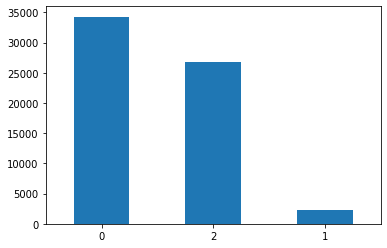

In [62]:
### Distribution of target classes
df['usage_class'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0)

### Drop columns:
#### Person, offer_id - dropping id columns
#### event_=_offer completed,event_=_offer received,usage_rate - dropped as they were used in creating target variable
#### became_member_on - dropped as join_month is used instead

In [63]:
df = df.drop(['person','offer_id','event_=_offer completed','event_=_offer received','usage_rate','became_member_on'],axis = 1)

In [64]:
df.head(10)

,event_=_offer viewed,transaction_amount,event_=_transaction,reward,difficulty,duration,offer_type,Is Offer on email,Is Offer on mobile,Is Offer on social,Is Offer on web,gender,age,income,join_month,usage_class
0,0,127.60,8,2,10,7,discount,1,1,0,1,M,33,72000.000000,4,2
1,1,127.60,8,0,0,4,informational,1,1,0,1,M,33,72000.000000,4,0
2,1,127.60,8,0,0,3,informational,1,1,1,0,M,33,72000.000000,4,0
3,1,127.60,8,5,5,5,bogo,1,1,1,1,M,33,72000.000000,4,2
4,1,127.60,8,2,10,10,discount,1,1,1,1,M,33,72000.000000,4,2
5,2,4.09,3,5,5,5,bogo,1,1,1,1,Unwilling to specify,118,65404.991568,4,0
6,1,79.46,5,5,20,10,discount,1,0,0,1,O,40,57000.000000,1,2
7,1,79.46,5,3,7,7,discount,1,1,1,1,O,40,57000.000000,1,2
8,1,79.46,5,0,0,4,informational,1,1,0,1,O,40,57000.000000,1,0
9,1,79.46,5,0,0,3,informational,1,1,1,0,O,40,57000.000000,1,0


In [65]:
# To do
# Categorical encoding
# Train test split
# Feature scaling
# Hyperparameter tuning
# Model fit and evaluation metrics

### Categorical features encoding for the left out categorical features - offer_type and gender

In [66]:
## For offer_type
df = pd.concat([df, pd.get_dummies(df['offer_type'], prefix = 'offer_type', prefix_sep = '_=_')], axis = 1).drop('offer_type', axis = 1)

In [67]:
## For region
df = pd.concat([df, pd.get_dummies(df['gender'], prefix = 'gender', prefix_sep = '_=_')], axis = 1).drop('gender', axis = 1)

In [68]:
df.head()

,event_=_offer viewed,transaction_amount,event_=_transaction,reward,difficulty,duration,Is Offer on email,Is Offer on mobile,Is Offer on social,Is Offer on web,age,income,join_month,usage_class,offer_type_=_bogo,offer_type_=_discount,offer_type_=_informational,gender_=_F,gender_=_M,gender_=_O,gender_=_Unwilling to specify
0,0,127.6,8,2,10,7,1,1,0,1,33,72000.0,4,2,0,1,0,0,1,0,0
1,1,127.6,8,0,0,4,1,1,0,1,33,72000.0,4,0,0,0,1,0,1,0,0
2,1,127.6,8,0,0,3,1,1,1,0,33,72000.0,4,0,0,0,1,0,1,0,0
3,1,127.6,8,5,5,5,1,1,1,1,33,72000.0,4,2,1,0,0,0,1,0,0
4,1,127.6,8,2,10,10,1,1,1,1,33,72000.0,4,2,0,1,0,0,1,0,0


In [69]:
df.shape

(63288, 21)

In [70]:
df.describe()

,event_=_offer viewed,transaction_amount,event_=_transaction,reward,difficulty,duration,Is Offer on email,Is Offer on mobile,Is Offer on social,Is Offer on web,age,income,join_month,offer_type_=_bogo,offer_type_=_discount,offer_type_=_informational,gender_=_F,gender_=_M,gender_=_O,gender_=_Unwilling to specify
count,63288.00000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.0,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000
mean,0.91210,106.434725,8.336636,4.206232,7.711572,6.504819,1.0,0.899286,0.599529,0.799425,62.462110,65390.684837,6.675784,0.400092,0.400013,0.199896,0.360384,0.500016,0.012151,0.127449
std,0.61458,127.616131,5.195173,3.402914,5.541480,2.203565,0.0,0.300952,0.489998,0.400434,26.729957,20201.266604,3.490544,0.489921,0.489904,0.399925,0.480116,0.500004,0.109560,0.333478
min,0.00000,0.000000,0.000000,0.000000,0.000000,3.000000,1.0,0.000000,0.000000,0.000000,18.000000,30000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,22.280000,4.000000,2.000000,5.000000,5.000000,1.0,1.000000,0.000000,1.000000,45.000000,51000.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.00000,70.780000,7.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,58.000000,65404.991568,7.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.00000,151.670000,11.000000,5.000000,10.000000,7.000000,1.0,1.000000,1.000000,1.000000,73.000000,76000.000000,10.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,5.00000,1608.690000,36.000000,10.000000,20.000000,10.000000,1.0,1.000000,1.000000,1.000000,118.000000,120000.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
correlation = (df.drop('Is Offer on email', axis = 1)).corr()

<AxesSubplot:>

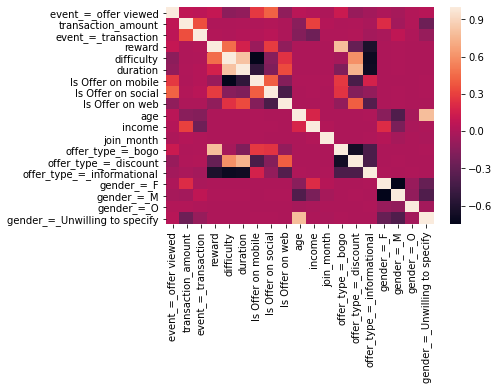

In [72]:
sns.heatmap(correlation)

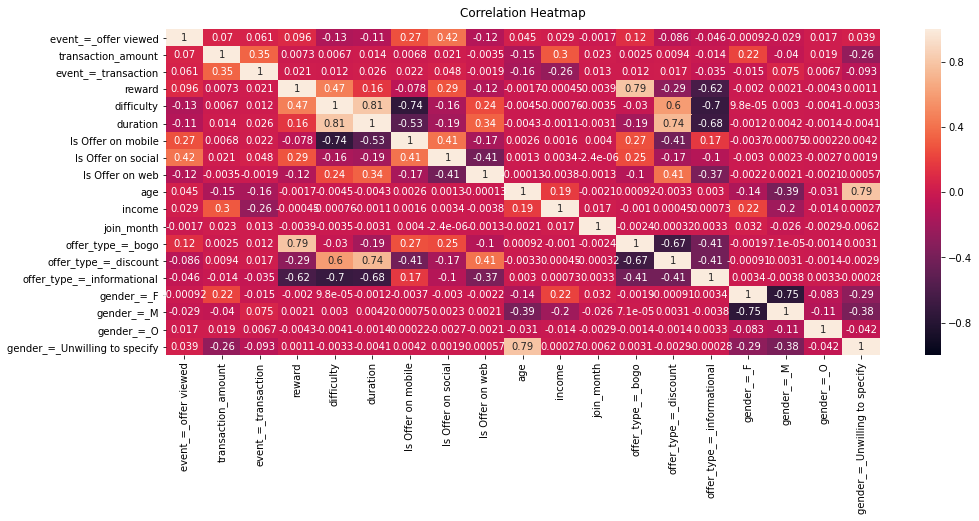

In [73]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(correlation, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [74]:
## Removing correlated variables did not help improving model results

### Train test split

In [75]:
x = df.drop('usage_class',axis=1)
y = df['usage_class'].astype('int')

In [76]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size = 0.2, random_state = 1234)

### Feature Scaling

In [77]:
scaler = MinMaxScaler()

In [78]:
x.columns

Index(['event_=_offer viewed', 'transaction_amount', 'event_=_transaction',
       'reward', 'difficulty', 'duration', 'Is Offer on email',
       'Is Offer on mobile', 'Is Offer on social', 'Is Offer on web', 'age',
       'income', 'join_month', 'offer_type_=_bogo', 'offer_type_=_discount',
       'offer_type_=_informational', 'gender_=_F', 'gender_=_M', 'gender_=_O',
       'gender_=_Unwilling to specify'],
      dtype='object')

In [79]:
scaling_features = ['transaction_amount', 'reward', 'difficulty','duration', 'age', 'income','join_month']

In [80]:
x_train[scaling_features] = scaler.fit_transform(x_train[scaling_features])

C:\Users\PKN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PKN\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [81]:
x_test[scaling_features] = scaler.fit_transform(x_test[scaling_features])

C:\Users\PKN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PKN\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [82]:
x_train.shape,x_test.shape

((50630, 20), (12658, 20))

In [83]:
x_train.head()

,event_=_offer viewed,transaction_amount,event_=_transaction,reward,difficulty,duration,Is Offer on email,Is Offer on mobile,Is Offer on social,Is Offer on web,age,income,join_month,offer_type_=_bogo,offer_type_=_discount,offer_type_=_informational,gender_=_F,gender_=_M,gender_=_O,gender_=_Unwilling to specify
20231,1,0.010188,5,0.3,0.35,0.571429,1,1,1,1,0.06,0.088889,0.454545,0,1,0,0,1,0,0
49685,0,0.027121,15,0.0,0.00,0.142857,1,1,0,1,0.16,0.177778,0.818182,0,0,1,0,1,0,0
25370,1,0.085834,6,0.2,0.50,1.000000,1,1,1,1,0.39,0.700000,0.545455,0,1,0,1,0,0,0
38880,0,0.016218,11,0.5,0.25,0.571429,1,1,0,1,1.00,0.393389,0.000000,1,0,0,0,0,0,1
59982,1,0.194506,12,0.0,0.00,0.000000,1,1,1,0,0.48,0.711111,0.090909,0,0,1,1,0,0,0


### Hyperparameter tuning

#### Random search

In [84]:
parameters = {'boosting_type': ['gbdt','dart'],'learning_rate' : [0.05,0.06,0.07,0.08,0.09,0.1,0.2,0.3,0.5], 'max_depth':[5,10], 'reg_alpha' :[0,0.01,0.1,0.5,1],
             'reg_lambda':[0,0.01,0.1,0.5,1], 'n_estimators' : [10,20,30,50,100,150,200,300], 'bagging_fraction' :[0.1,0.3,0.5,0.8,1],
             'bagging_freq':[10,50,100,200,500], 'feature_fraction': [0.1,0.3,0.5,0.8]}

#clf = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), parameters, cv = model_selection.StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1234))
clf = model_selection.RandomizedSearchCV(lgb.LGBMClassifier(random_state  = 1234),param_distributions = parameters, cv = model_selection.StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1234), n_iter = 20, scoring = 'accuracy')
clf.fit(x_train, y_train)
print('best parameters: ', clf.best_params_)

best parameters:  {'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.1, 'feature_fraction': 0.8, 'boosting_type': 'gbdt', 'bagging_freq': 100, 'bagging_fraction': 1}


#### Bayesian Optimization

In [85]:
def lgbm_evaluate(**param_range): 
    params = {}
    #params['boosting_type'] = 'gbdt'
    params['objective'] = 'multiclass'
    params['metric'] = 'multi_logloss'
    params['num_class'] = 3
    params['learning_rate']=param_range['learning_rate']
    params['feature_fraction']=param_range['feature_fraction']
    params['bagging_fraction']=param_range['bagging_fraction']
    params['bagging_freq']=int(round(param_range['bagging_freq']))
    params['max_depth']=int(round(param_range['max_depth']))
    params['reg_alpha']=param_range['reg_alpha']
    params['reg_lambda']=param_range['reg_lambda']
    #params['num_boost_round']=int(round(param_range['num_boost_round ']))
    #params['min_gain_to_split']=min_gain_to_split
    #lgb_train_data = lgb.Dataset(x_train, label=y_train, free_raw_data = None)
    lgb_train_data = lgb.Dataset(x_train, label=y_train, free_raw_data=False )
    cv_result = lgb.cv(params,lgb_train_data,num_boost_round = 100, nfold=5, seed=1234, stratified=True,shuffle = True, metrics=['multi_logloss'])
    return -min(cv_result['multi_logloss-mean'])

    #cv_result = lgb.cv(params,lgb_train_data, nfold =5, stratified  = True, shuffle  = True, seed =1234)

In [86]:
param_range={
#'boosting_type':['gbdt','dart'],  
'learning_rate':(0.05, 0.5),
'feature_fraction': (0.1, 1),
'bagging_fraction': (0.1, 1),
'bagging_freq':(0, 500),
'max_depth': (5, 10),
'reg_alpha':(0,1),
'reg_lambda':(0,1)}
#'min_gain_to_split':(0, 5)}

In [87]:
bo = BayesianOptimization(lgbm_evaluate, param_range)
bo.maximize(init_points = 5, n_iter = 20, acq = 'ei')

|   iter    |  target   | baggin... | baggin... | featur... | learni... | max_depth | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.3628   |  0.2843   |  56.94    |  0.2755   |  0.3048   |  7.79     |  0.5103   |  0.3004   |
|  2        | -0.3448   |  0.6899   |  289.2    |  0.7162   |  0.3451   |  6.038    |  0.3434   |  0.5288   |
|  3        | -0.3521   |  0.3992   |  472.4    |  0.7075   |  0.3656   |  8.625    |  0.4271   |  0.4234   |
|  4        | -0.3589   |  0.5406   |  328.6    |  0.2292   |  0.17     |  6.174    |  0.7798   |  0.6375   |
|  5        | -0.3442   |  0.7867   |  145.5    |  0.8063   |  0.3884   |  6.676    |  0.7173   |  0.4202   |
|  6        | -0.3599   |  0.2495   |  145.6    |  0.4519   |  0.3502   |  6.73     |  0.5804   |  0.6009   |
|  7        | -0.3675   |  0.1654   |  207.4    |  0.441    |  0.383    |  6.246    |  0.6487   |  0.4343   |
|  8      

In [88]:
parameters = bo.max['params']

In [89]:
final_parameters = {}
final_parameters.update({'boosting_type':'gbdt'})
for k, v in parameters.items():
    if k in ['bagging_freq','min_data_in_leaf','max_depth','max_bin','num_leaves','k_range']:
        final_parameters[k] = int(round(v))
    else:
        final_parameters[k] = round(v,4)

In [90]:
final_parameters

{'boosting_type': 'gbdt',
 'bagging_fraction': 0.9372,
 'bagging_freq': 414,
 'feature_fraction': 0.7686,
 'learning_rate': 0.246,
 'max_depth': 9,
 'reg_alpha': 0.1637,
 'reg_lambda': 0.0862}

### Model fitting and obtaining evaluation metrics

In [99]:
light = lgb.LGBMClassifier(boosting_type = 'gbdt', learning_rate  = 0.1, max_depth = 5, reg_alpha  = 1, reg_lambda = 0.1,
                           bagging_fraction= 1, bagging_freq = 100,feature_fraction = 0.8, n_estimators = 150, random_state  = 1234)
                          #class_weight = {0:9.32605178,1:3.49065031,2:0.38368658})
 ### Random search parameters are found to be optimal   

In [100]:
light.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=1, bagging_freq=100, feature_fraction=0.8,
               max_depth=5, n_estimators=150, random_state=1234, reg_alpha=1,
               reg_lambda=0.1)

In [101]:
y_pred = light.predict(x_test)

In [102]:
print(metrics.accuracy_score(y_test, y_pred))

0.8532153578764418


In [103]:
light_report = """
The evaluation report of LightGBM is:
Confusion Matrix:
{}
Accuracy: {}
""".format(metrics.confusion_matrix(y_test, y_pred),
           metrics.accuracy_score(y_test, y_pred))
print(light_report)
print('The classification report of LightGBM:\n {}'
      .format(metrics.classification_report(y_test, y_pred)))


The evaluation report of LightGBM is:
Confusion Matrix:
[[5789   87  983]
 [  79  128  260]
 [ 397   52 4883]]
Accuracy: 0.8532153578764418

The classification report of LightGBM:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      6859
           1       0.48      0.27      0.35       467
           2       0.80      0.92      0.85      5332

    accuracy                           0.85     12658
   macro avg       0.73      0.68      0.69     12658
weighted avg       0.85      0.85      0.85     12658



In [104]:
light_prob = light.predict_proba(x_test)

In [105]:
n_classes = 3

In [106]:
#y_train = label_binarize(y_train, classes=[0, 1, 2])
y_test = label_binarize(y_test, classes=[0, 1, 2])

In [107]:
y_test

array([[1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [108]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], light_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), light_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

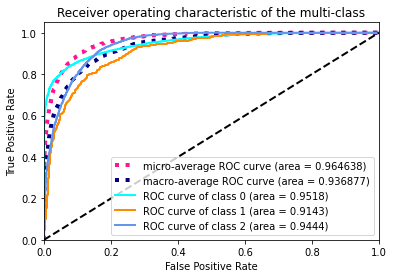

In [109]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.6f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.6f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of the multi-class')
plt.legend(loc="lower right")
plt.show()

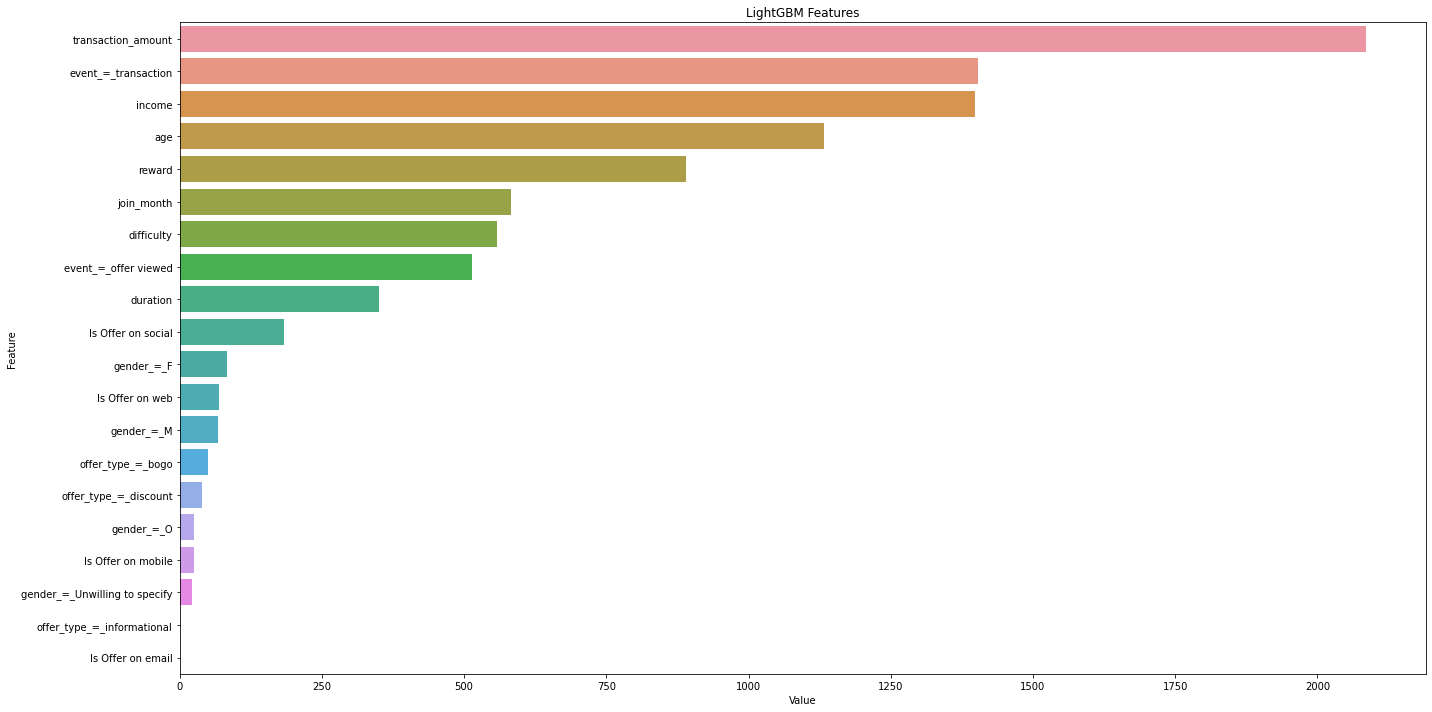

In [110]:
# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(light.feature_importances_,x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()